In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from functions.datacleaning import MoscowHousing as mh

In [2]:
# Get data
data = mh(
          coordinates=None,
          data_train="../prepared_data/train_prepared_category_1.csv",
          data_test="../prepared_data/test_prepared_category_1.csv",
          # test_prepared.csv is already complete
          need_correction=False,
          # Base float values are already normalized with 0 as mean
          normalize = False,
          # Passing floats (not really necessary)
          features_float = ["area_total", 
                            "distance", 
                            "area_kitchen", 
                            "area_living", 
                            "ceiling",
                            "distance_metro"]
        )

XTrain, YTrain = data.get_data_train()

In [3]:
# Features to remove in both training and test data
features_remove_train = [
    'Unnamed: 0', 'area_total', 'area_kitchen', 'area_living',
    'floor', 'rooms', 'ceiling', 'bathrooms_shared', 'bathrooms_private',
    'windows_court', 'windows_street', 'balconies', 'loggias', 'phones',
    'building_id', 'latitude', 'longitude', 'street', 'address',
    'stories', 'parking', 'distance', 'distance_metro',
    'seller_0.0', 'seller_1.0', 'seller_2.0', 'seller_3.0', 'seller_nan',
    'layout_0.0', 'layout_1.0', 'layout_2.0', 'layout_nan', 'condition_0.0',
    'condition_1.0', 'condition_2.0', 'condition_3.0', 'condition_nan', 'material_0.0', 'material_1.0', 'material_2.0',
    'material_3.0', 'material_4.0', 'material_5.0', 'material_6.0',
    'material_nan', 'garbage_chute_0.0', 'garbage_chute_1.0',
    'garbage_chute_nan', 'heating_0.0', 'heating_1.0', 'heating_2.0',
    'heating_3.0', 'heating_nan', 'elevator', 'elevator_no'
]

"""features_remove_train = ["area_kitchen", "area_living", "layout",
                         "seller", "condition", "stories", "distance",
                         "windows_court", "windows_street", "distance_metro",
                         "bathrooms_shared", "bathrooms_private",
                         "balconies", "loggias", "countpattern_street",
                         "material", "ceiling", "area_total", "price_per_square_meter",
                         "elevator_without", "floor", "rooms", "district",
                         "elevator_passenger", "elevator_service", "parking", 
                         "garbage_chute", "heating", "latitude", "longitude", 
                         "street", "address", "phones"]"""

print(XTrain.columns.values)

# First prep - remove unwanted features
X_Train = XTrain.drop(features_remove_train, axis=1)

['Unnamed: 0' 'id' 'price' 'area_total' 'area_kitchen' 'area_living'
 'floor' 'rooms' 'ceiling' 'bathrooms_shared' 'bathrooms_private'
 'windows_court' 'windows_street' 'balconies' 'loggias' 'phones'
 'building_id' 'latitude' 'longitude' 'district' 'street' 'address'
 'constructed' 'stories' 'parking' 'distance' 'distance_metro'
 'seller_0.0' 'seller_1.0' 'seller_2.0' 'seller_3.0' 'seller_nan'
 'layout_0.0' 'layout_1.0' 'layout_2.0' 'layout_nan' 'condition_0.0'
 'condition_1.0' 'condition_2.0' 'condition_3.0' 'condition_nan' 'new_0.0'
 'new_1.0' 'new_nan' 'material_0.0' 'material_1.0' 'material_2.0'
 'material_3.0' 'material_4.0' 'material_5.0' 'material_6.0'
 'material_nan' 'garbage_chute_0.0' 'garbage_chute_1.0'
 'garbage_chute_nan' 'heating_0.0' 'heating_1.0' 'heating_2.0'
 'heating_3.0' 'heating_nan' 'elevator' 'elevator_no']


In [4]:
print("number of nans in new", len(X_Train["new_nan"][X_Train["new_nan"] == 1.0])) # 264
print("number of nans in constructed", len(X_Train.loc[X_Train["constructed"].isnull()].index))

number of nans in new 264
number of nans in constructed 794


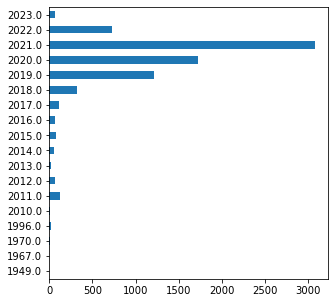

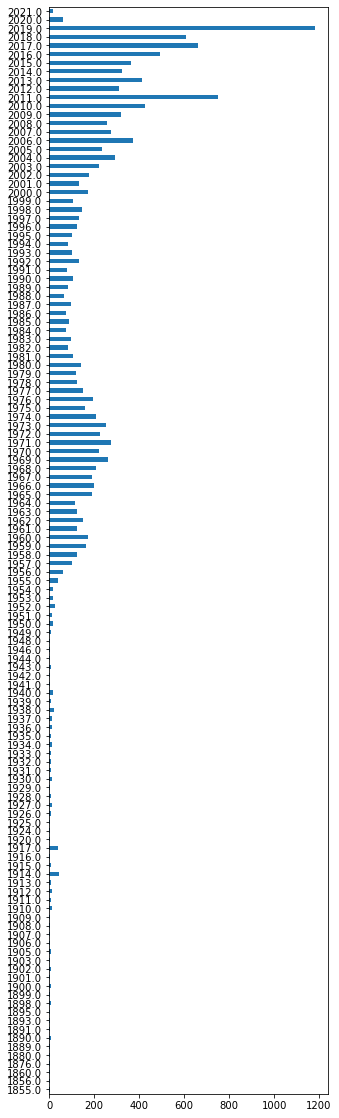

In [5]:
# 133/264 apts has constructed value when new is null
# (new can be set on 133 apts based on constructed)
nan = X_Train.loc[(X_Train["new_nan"] > 0) & (X_Train["constructed"].isna())]
new = X_Train.loc[(X_Train["new_1.0"] > 0) & (X_Train["constructed"].notnull())] # 1949-2023
old = X_Train.loc[(X_Train["new_0.0"] > 0) & (X_Train["constructed"].notnull())] # 1855-2021

new["constructed"].value_counts().sort_index(ascending=True).plot(kind = 'barh', figsize=(5,5))
plt.show()
plt.close()
old["constructed"].value_counts().sort_index(ascending=True).plot(kind = 'barh', figsize=(5,20))
plt.show()

constructedValues = X_Train.loc[(X_Train["constructed"].notnull()) & (X_Train["new_nan"] == 0)] # 
constructedNan = X_Train.loc[(X_Train["constructed"].isnull()) & (X_Train["new_nan"] == 0)] # 663 new values that can be used to set constructed 

142
Test MSLE: 0.81


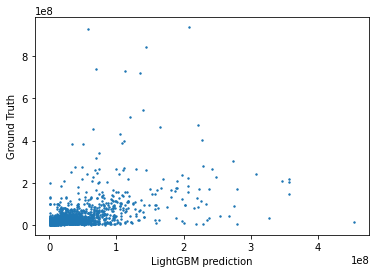

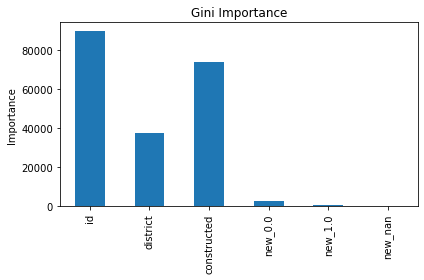

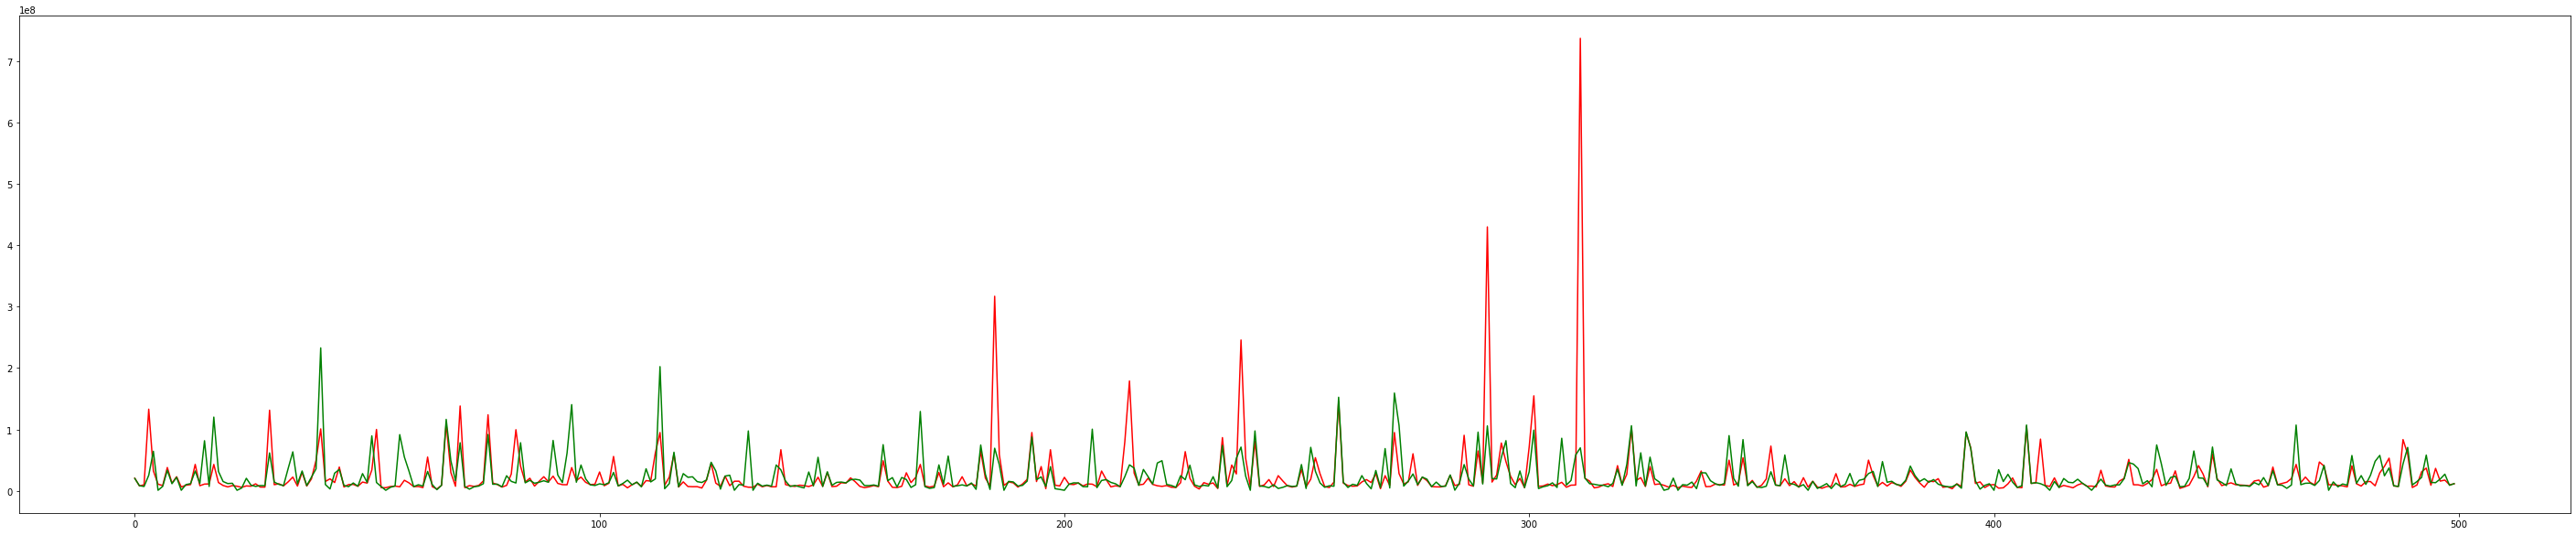

In [6]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error

def predict_and_analyze(dataset):
    # split training data into test and training split
    X_train1, X_test1 = train_test_split(dataset, test_size=0.15, random_state=42)

    # remove apartments with very high price from training-test data
    # qhigh = X_train1["price"].quantile(0.99)
    # X_train1 = X_train1[(X_train1["price"] < qhigh)]

    # get price columns 
    y_train = X_train1.pop("price")
    y_test = X_test1.pop("price")

    model5 = lgb.LGBMRegressor(
        num_leaves=100,
        max_depth=10, 
        random_state=42,
        metric='msle',
        n_jobs=4, 
        n_estimators=3000,
        colsample_bytree=0.95,
        subsample=0.9,
        learning_rate=0.05
    )

    model5.fit(X_train1, y_train)

    lgbm_prediction = model5.predict(X_test1)

    faulty_rows = []
    for i in range(len(lgbm_prediction)):
        if lgbm_prediction[i] < 900000:
            lgbm_prediction[i] = 900000
            faulty_rows.append(i)

    # list apartments resulting in too low price
    print(len(faulty_rows))

    lgb_msle = round(mean_squared_log_error(lgbm_prediction, y_test), 2)
    print('Test MSLE:', lgb_msle)

    # correct predictions are on the diagonal
    plt.scatter(lgbm_prediction, y_test, s=2)
    plt.xlabel('LightGBM prediction')
    plt.ylabel('Ground Truth')
    plt.show()

    # important features
    importances = model5.feature_importances_
    forest_importances = pd.Series(importances, index=X_train1.columns)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Gini Importance")
    ax.set_ylabel("Importance")
    fig.tight_layout()

    # red is real prices, green is predicted prices
    plt.figure(figsize=(50, 10))
    plt.plot(y_test.values[:500], color = 'red')
    plt.plot(lgbm_prediction[:500], color = 'green')
    plt.show()
    

predict_and_analyze(X_Train)

Sets null values in constructed to random year in manual set range using new column.
Remove new column. 

Has almost no impact on simple model with a few selected features, but might make the data less noisy for more complex models.
When only using the constructed column vs only using constructed+new, it performs a little worse. From ~0.69 to 0.71 MSLE. 

In [7]:
X_Train.head()

,id,price,district,constructed,new_0.0,new_1.0,new_nan
0,0,7139520.0,3,2021.0,0,1,0
1,1,10500000.0,4,2010.0,1,0,0
2,2,9019650.0,4,2021.0,0,1,0
3,3,10500000.0,4,2010.0,1,0,0
4,4,13900000.0,4,2017.0,1,0,0


0.04763337091037467
0 2012.5
1 2015.0
2 2013.0
3 2015.0
4 2011.0
5 2014.5
6 2013.0
7 2011.0
8 2016.0
9 2019.0
10 2014.0
11 2013.0


/var/folders/49/l2945tw56gg9jn_kjxk7_h440000gp/T/ipykernel_13961/471972026.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Train2["constructed"][X_Train2["constructed"].isnull()] = mean_all


0
Test MSLE: 0.71


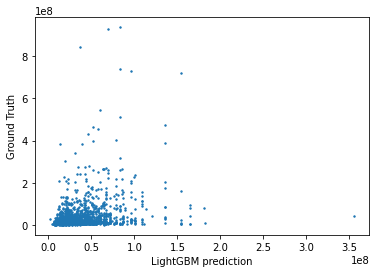

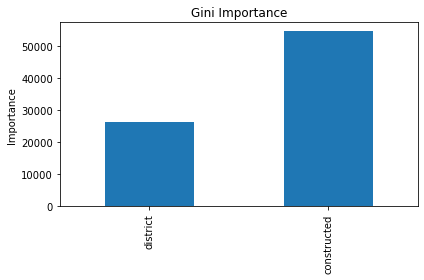

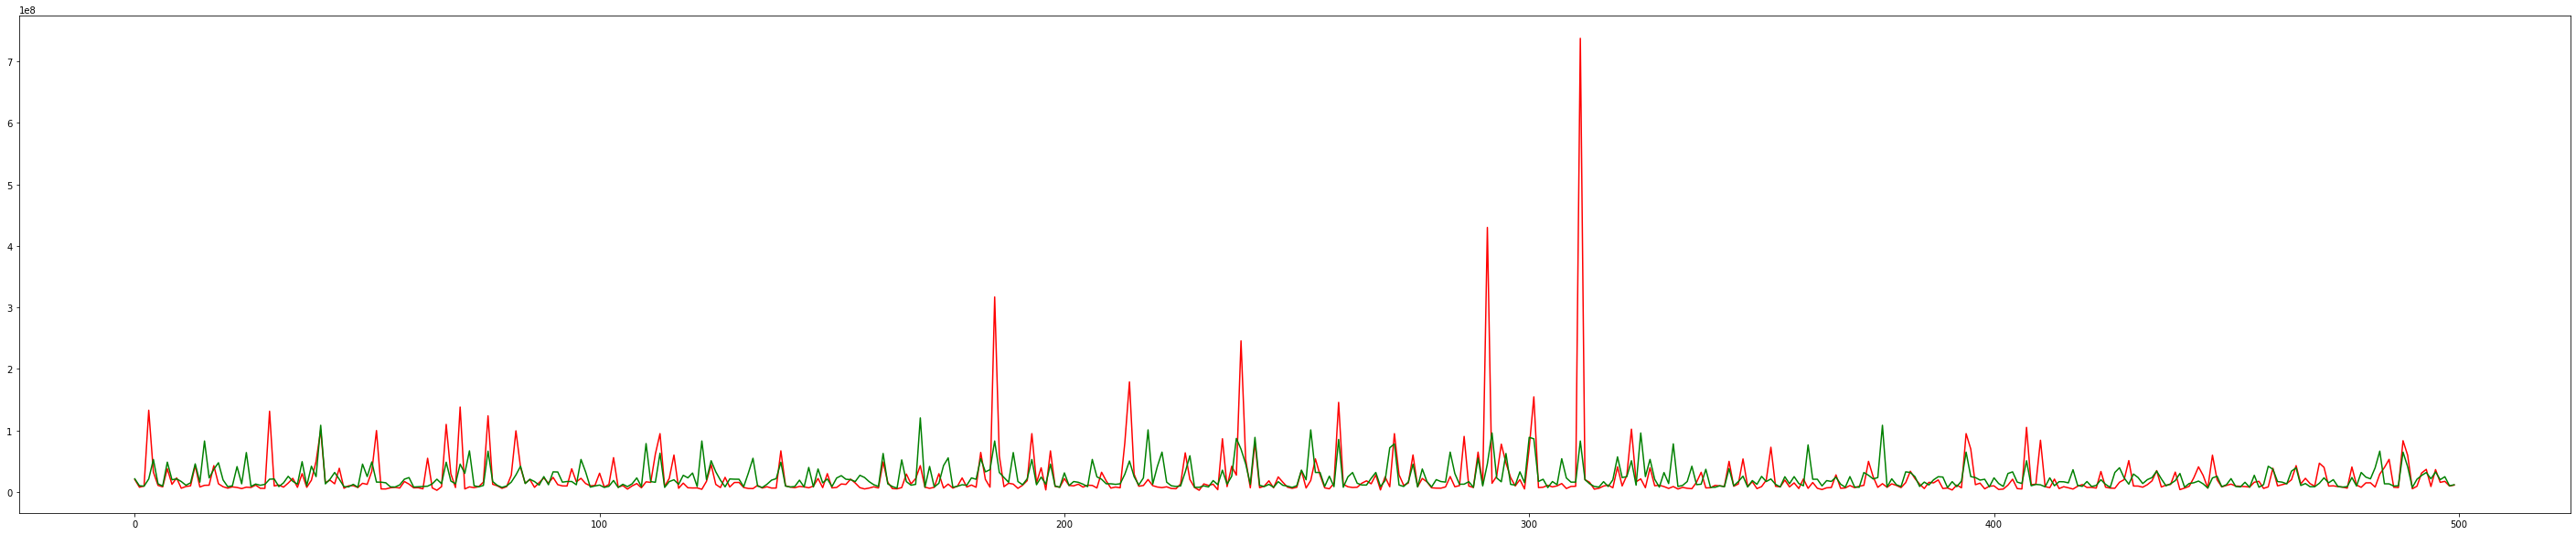

In [8]:
X_Train2 = X_Train.copy()

X_Train2 = X_Train2.drop(["id"], axis=1)

print(XTrain["constructed"].corr(XTrain["price"]))

for i in range(0, 12):
    a = X_Train2[(X_Train2["district"] == i) & (X_Train2["constructed"].notnull())]

    #Finding the mean of the column having NaN
    print(i, a["constructed"].median())

"""
   mean median
0  2002 2012.5
1  2005 2015.0
2  2002 2013.0
3  2004 2015.0
4  2000 2011.0
5  2003 2014.5
6  2003 2013.0
7  2001 2011.0
8  2005 2016.0
9  2010 2019.0
10 2003 2014.0
11 2002 2013.0
""" 
# district 9 is newer, otherwise they are pretty much the same    

# set constructed on rows with new=True to random in range around manually picked year
""" is_new = (X_Train2["constructed"].notnull()) & (X_Train2["new_1.0"] == 1.0)
new = X_Train2.loc[is_new]
num_new = len(X_Train2.loc[is_new].index)
mean_new = int(new["constructed"].mean())
X_Train2["constructed"][(X_Train2["constructed"].isnull()) & (X_Train2["new_1.0"] == 1.0)] = mean_new # np.random.randint(2015, 2021, num_new) """

""" # set constructed on rows with new=True to random in range around manually picked year
is_old = (X_Train2["constructed"].notnull()) & (X_Train2["new_1.0"] == 0.0)
old = X_Train2.loc[is_old]
num_old = len(old.index)
mean_old = int(old["constructed"].mean())
X_Train2["constructed"][(X_Train2["constructed"].isnull()) & (X_Train2["new_1.0"] == 0.0)] = mean_old # np.random.randint(1955, 1985, num_old)
"""  
# replace null values with random in range around total mean value
mean_all = int(X_Train2["constructed"].mean())
num_null = len(X_Train2.loc[X_Train2["constructed"].isnull()].index)
X_Train2["constructed"][X_Train2["constructed"].isnull()] = mean_all

X_Train2.pop("new_1.0")
X_Train2.pop("new_0.0")
X_Train2.pop("new_nan")

# X_Train2["constructed"].value_counts().sort_index(ascending=True).plot(kind = 'barh', figsize=(5,20))
# plt.show()

predict_and_analyze(X_Train2)